In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/SpotifyFeatures.csv")

# Basic info
print(df.shape)
print(df.head())

# Check missing values
print(df.isnull().sum())

# Column names
print(df.columns.tolist())


(232725, 18)
   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737         

In [2]:
# Drop duplicates
df = df.drop_duplicates()

# Handle missing values (if any)
df = df.dropna()

# Keep only useful columns for recommendation
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']

music_df = df[['track_name','artist_name','genre'] + features]
music_df.reset_index(drop=True, inplace=True)

print(music_df.shape)
music_df.head()


(232724, 14)


,track_name,artist_name,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,popularity
0,C'est beau de faire un Show,Henri Salvador,Movie,0.611,0.389,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814,99373,0
1,Perdu d'avance (par Gad Elmaleh),Martin & les fées,Movie,0.246,0.590,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816,137373,1
2,Don't Let Me Be Lonely Tonight,Joseph Williams,Movie,0.952,0.663,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368,170267,3
3,Dis-moi Monsieur Gordon Cooper,Henri Salvador,Movie,0.703,0.240,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227,152427,0
4,Ouverture,Fabien Nataf,Movie,0.950,0.331,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390,82625,4


2. Feature Scaling

We have to normalized values so distance/similarity makes sense.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(music_df[features])


3. Build Content-Based Recommender

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# -------------------------------
# 1. Load Data
# -------------------------------
df = pd.read_csv("../data/SpotifyFeatures.csv")

# Drop duplicates + NA
df = df.drop_duplicates().dropna()

# Select features
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']

music_df = df[['track_name','artist_name','genre'] + features].reset_index(drop=True)

# -------------------------------
# 2. Scale Features
# -------------------------------
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(music_df[features])

# -------------------------------
# 3. Fit Nearest Neighbors Model
# -------------------------------
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(scaled_features)

# -------------------------------
# 4. Recommender Function
# -------------------------------
def recommend_song(song_name, num_recommendations=5):
    # Find song index
    idx = music_df[music_df['track_name'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return f"❌ Song '{song_name}' not found in dataset."
    idx = idx[0]

    # Get nearest neighbors
    distances, indices = nn.kneighbors([scaled_features[idx]], n_neighbors=num_recommendations+1)

    # Skip first (same song)
    recs = music_df.iloc[indices[0][1:]]
    return recs[['track_name','artist_name','genre']]


4. Visualization

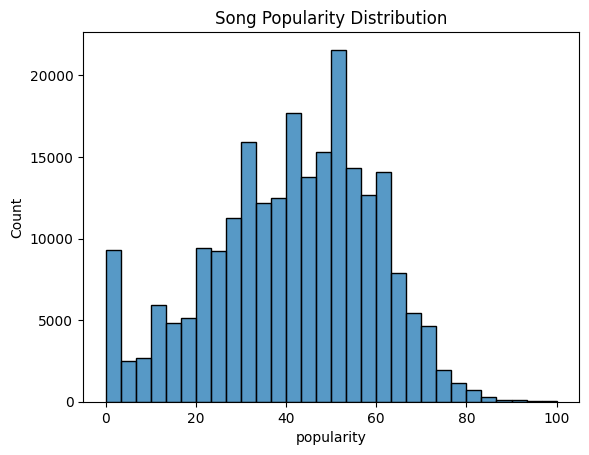

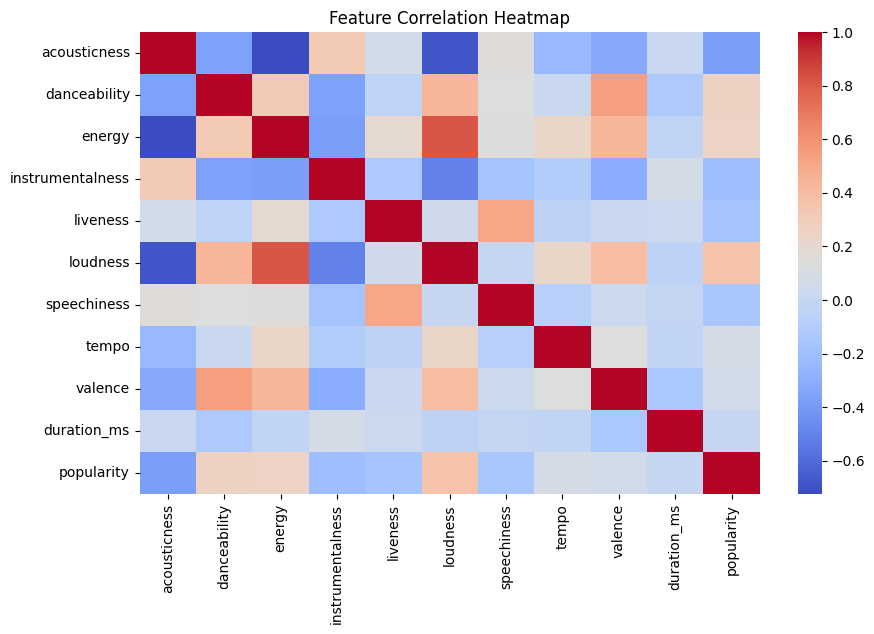

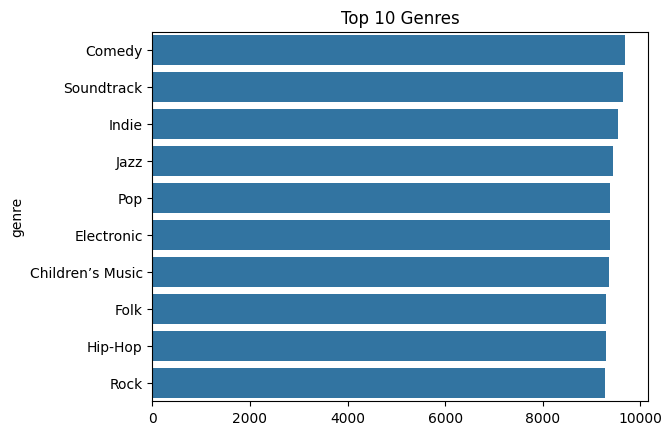

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of popularity
sns.histplot(music_df['popularity'], bins=30)
plt.title("Song Popularity Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(music_df[features].corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Top 10 genres
top_genres = music_df['genre'].value_counts().head(10)
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title("Top 10 Genres")
plt.show()


In [7]:
music_df.to_csv("../data/Spotify_Cleaned.csv", index=False)


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# -------------------------------
# 1. Load Data
# -------------------------------
df = pd.read_csv("../data/SpotifyFeatures.csv")

# Drop duplicates + NA
df = df.drop_duplicates().dropna()

# Select features
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']

music_df = df[['track_name','artist_name','genre'] + features].reset_index(drop=True)

# -------------------------------
# 2. Scale Features
# -------------------------------
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(music_df[features])

# -------------------------------
# 3. Fit Nearest Neighbors Model
# -------------------------------
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(scaled_features)

# -------------------------------
# 4. Advanced Recommender Function
# -------------------------------
def recommend_song(song_name, num_recommendations=5, genre_filter=None, popularity_weight=False):
    """
    Recommend songs based on similarity, with optional genre filtering 
    and popularity weighting.
    """
    # Find song index
    idx_list = music_df[music_df['track_name'].str.lower() == song_name.lower()].index.tolist()
    if len(idx_list) == 0:
        return f"❌ Song '{song_name}' not found in dataset."
    idx = idx_list[0]

    # Get nearest neighbors (fetch 50 candidates first)
    distances, indices = nn.kneighbors([scaled_features[idx]], n_neighbors=50)

    # Create DataFrame of recommendations
    recs = music_df.iloc[indices[0][1:]].copy()   # skip first (same song)
    recs["similarity"] = 1 - distances[0][1:]     # convert distance → similarity

    # Apply genre filter
    if genre_filter:
        recs = recs[recs['genre'].str.lower() == genre_filter.lower()]

    # If still empty after filter → fallback
    if recs.empty:
        return f"⚠️ No recommendations found for '{song_name}' with genre '{genre_filter}'. Try without filter."

    # Popularity weighting
    if popularity_weight:
        recs["popularity_norm"] = recs["popularity"] / 100
        recs["final_score"] = 0.7*recs["similarity"] + 0.3*recs["popularity_norm"]
        recs = recs.sort_values("final_score", ascending=False)
    else:
        recs = recs.sort_values("similarity", ascending=False)

    return recs[['track_name','artist_name','genre','popularity']].head(num_recommendations)


🎵 Playlist Generator Code

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# -------------------------------
# 1. Load Data
# -------------------------------
df = pd.read_csv("../data/SpotifyFeatures.csv")

# Drop duplicates + NA
df = df.drop_duplicates().dropna()

# Select features
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']

music_df = df[['track_name','artist_name','genre'] + features].reset_index(drop=True)

# -------------------------------
# 2. Scale Features
# -------------------------------
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(music_df[features])

# -------------------------------
# 3. Fit Nearest Neighbors Model
# -------------------------------
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(scaled_features)

# -------------------------------
# 4. Mood Ranges (custom)
# -------------------------------
mood_rules = {
    "happy":     {"valence": (0.6, 1.0), "energy": (0.5, 1.0)},
    "sad":       {"valence": (0.0, 0.4), "energy": (0.0, 0.5)},
    "chill":     {"valence": (0.4, 0.7), "energy": (0.2, 0.6)},
    "party":     {"valence": (0.6, 1.0), "energy": (0.7, 1.0)},
    "energetic": {"valence": (0.4, 0.8), "energy": (0.7, 1.0)}
}

# -------------------------------
# 5. Playlist Generator Function
# -------------------------------
def generate_playlist(seed_song=None, mood=None, genre=None, playlist_length=10, popularity_weight=True):
    """
    Generate a playlist based on seed song, mood, or genre.
    """
    recs = music_df.copy()

    # Mood filter
    if mood and mood.lower() in mood_rules:
        rules = mood_rules[mood.lower()]
        for feature, (low, high) in rules.items():
            recs = recs[(recs[feature] >= low) & (recs[feature] <= high)]

    # Genre filter
    if genre:
        recs = recs[recs['genre'].str.lower() == genre.lower()]

    # If seed song is provided → similarity-based
    if seed_song:
        idx_list = music_df[music_df['track_name'].str.lower() == seed_song.lower()].index.tolist()
        if len(idx_list) == 0:
            return f"❌ Seed song '{seed_song}' not found in dataset."
        idx = idx_list[0]

        distances, indices = nn.kneighbors([scaled_features[idx]], n_neighbors=200)
        recs = music_df.iloc[indices[0][1:]].copy()
        recs["similarity"] = 1 - distances[0][1:]

    # Popularity weighting
    if popularity_weight and not recs.empty:
        recs["popularity_norm"] = recs["popularity"] / 100
        if "similarity" in recs:
            recs["final_score"] = 0.7*recs["similarity"] + 0.3*recs["popularity_norm"]
        else:
            recs["final_score"] = recs["popularity_norm"]
        recs = recs.sort_values("final_score", ascending=False)
    elif "similarity" in recs:
        recs = recs.sort_values("similarity", ascending=False)

    # Return top N
    return recs[['track_name','artist_name','genre','popularity']].head(playlist_length)


# Setup & Data Loading

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option("display.max_columns", None)

# Load dataset
df = pd.read_csv("../data/SpotifyFeatures.csv")

# Basic info
print(df.shape)
df.head()
df.info()
df.describe()


(232725, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_si

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


# Data Cleaning

In [12]:
# Drop duplicates
df = df.drop_duplicates()

# Handle missing values
print(df.isnull().sum())
df = df.dropna()

# Reset index
df.reset_index(drop=True, inplace=True)


genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


# General Dataset Overview

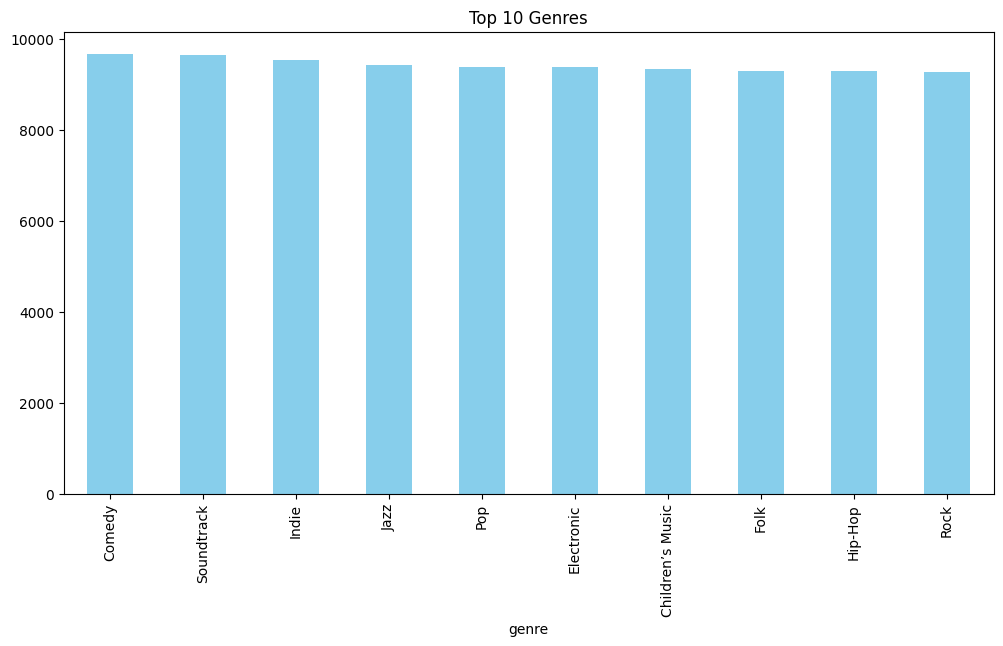

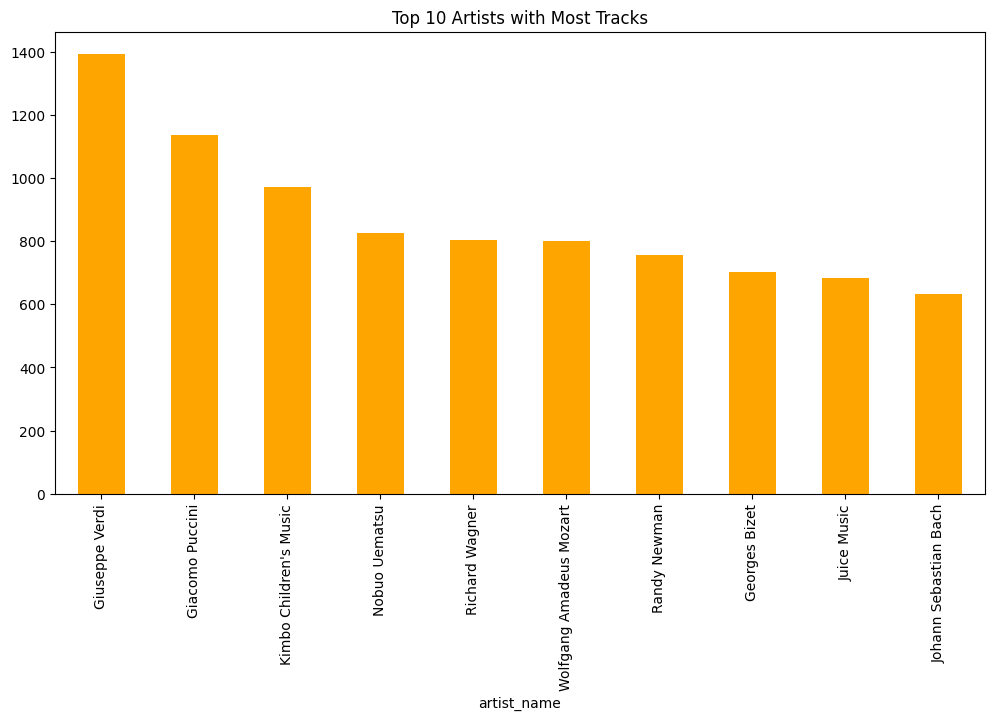

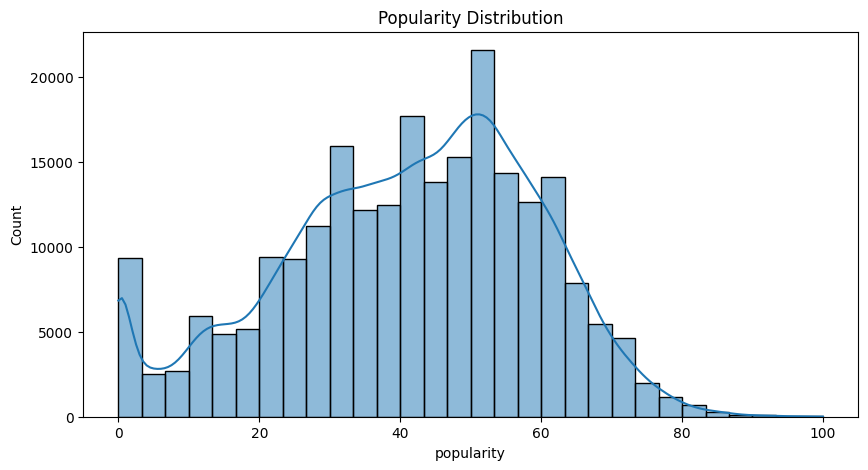

In [13]:
# Genre distribution
plt.figure(figsize=(12,6))
df['genre'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Genres")
plt.show()

# Artist distribution
plt.figure(figsize=(12,6))
df['artist_name'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Artists with Most Tracks")
plt.show()

# Popularity distribution
plt.figure(figsize=(10,5))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Popularity Distribution")
plt.show()


# Audio Features Analysis 

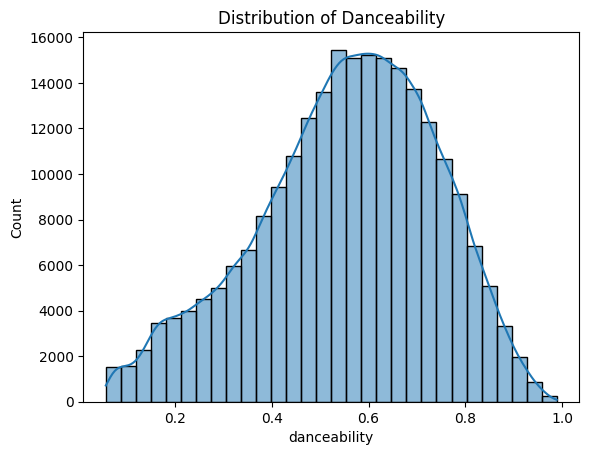

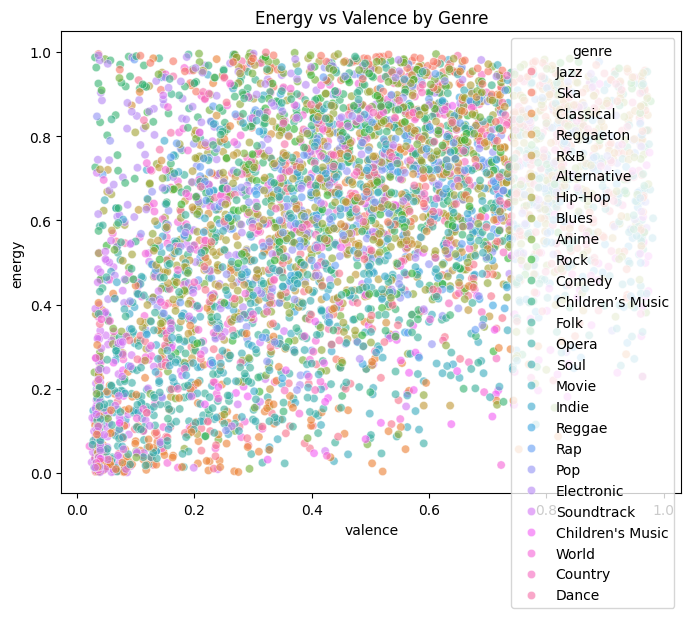

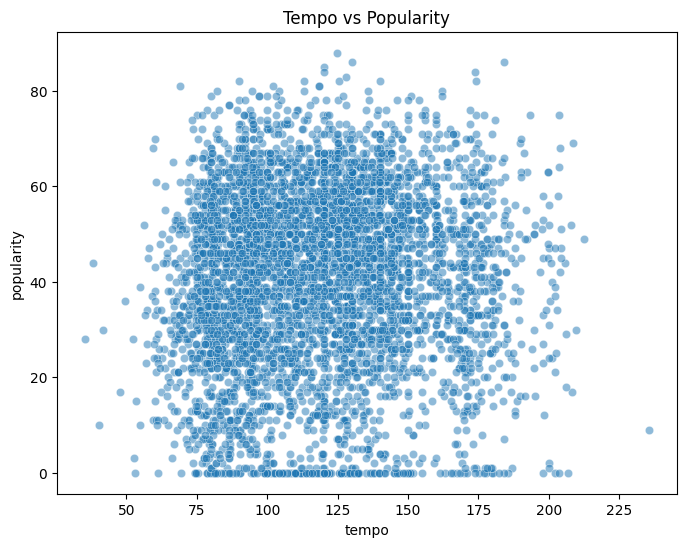

In [14]:
# Danceability
sns.histplot(df['danceability'], bins=30, kde=True)
plt.title("Distribution of Danceability")
plt.show()

# Energy vs Valence
plt.figure(figsize=(8,6))
sns.scatterplot(x='valence', y='energy', hue='genre', data=df.sample(5000), alpha=0.6)
plt.title("Energy vs Valence by Genre")
plt.show()

# Tempo vs Popularity
plt.figure(figsize=(8,6))
sns.scatterplot(x='tempo', y='popularity', data=df.sample(5000), alpha=0.5)
plt.title("Tempo vs Popularity")
plt.show()


# Correlation Analysis

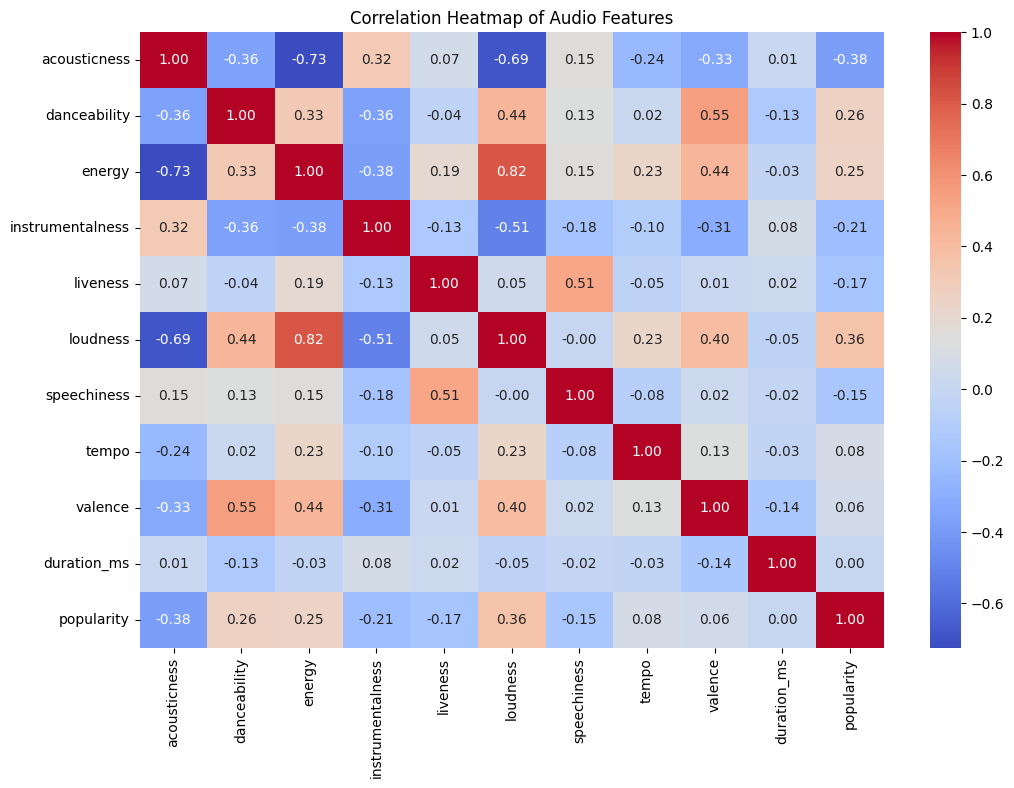

In [15]:
features = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence','duration_ms','popularity']

plt.figure(figsize=(12,8))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()


# Top 10 Genres : Shows dataset diversity.

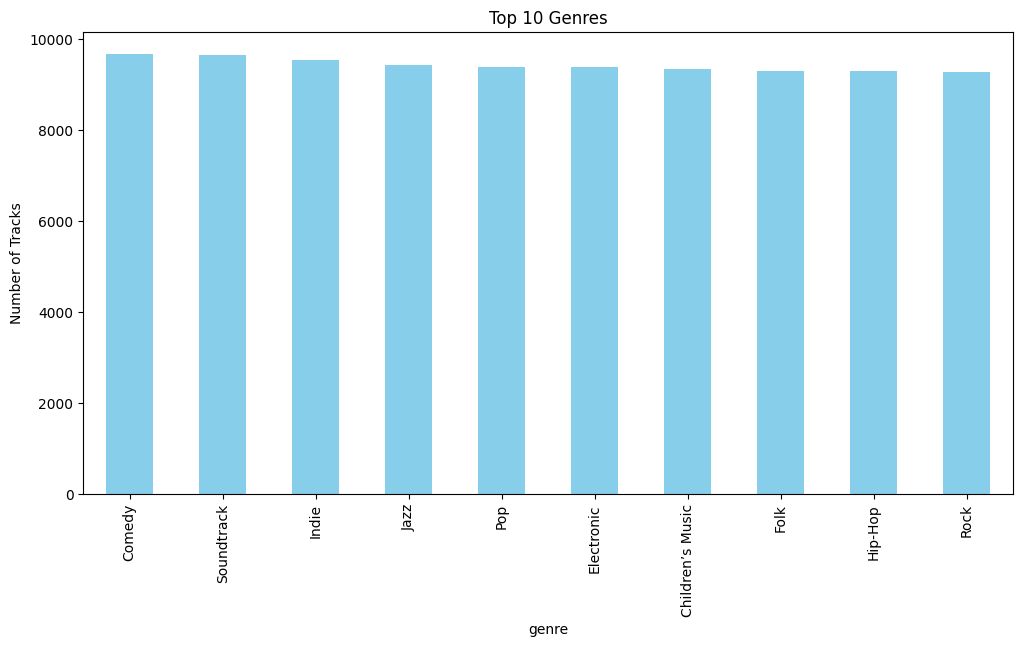

In [17]:
plt.figure(figsize=(12,6))
df['genre'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Genres")
plt.ylabel("Number of Tracks")
plt.savefig("../outputs/top_genres.png")
plt.show()


# Top 10 Artists with Most Tracks:

Highlights major contributors.

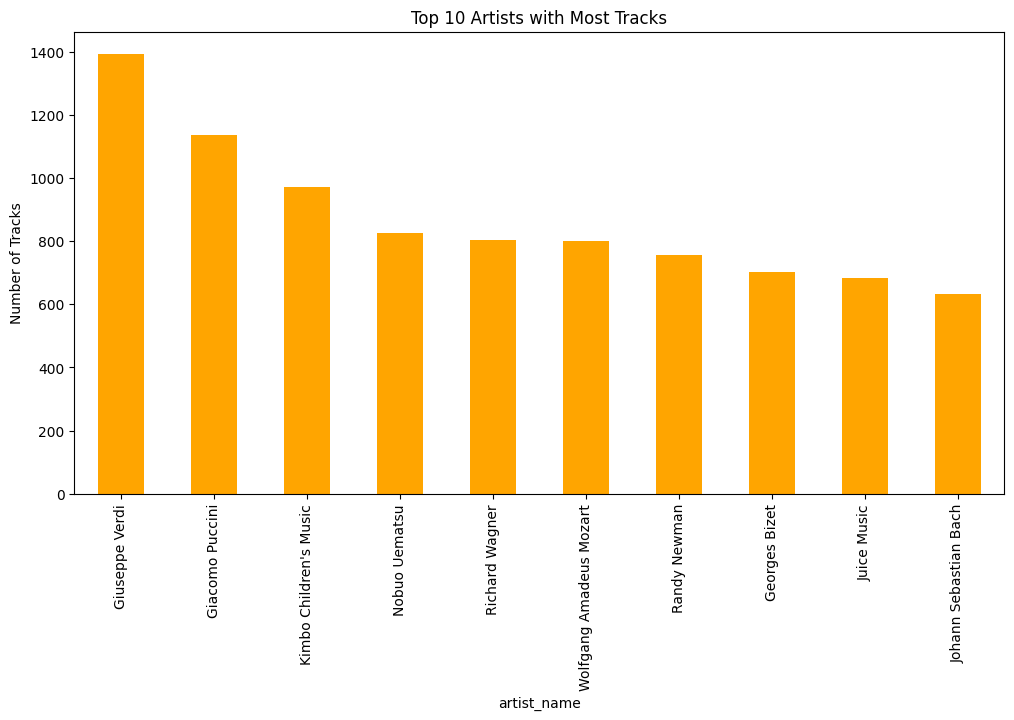

In [18]:
plt.figure(figsize=(12,6))
df['artist_name'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Artists with Most Tracks")
plt.ylabel("Number of Tracks")
plt.savefig("../outputs/top_artists.png")
plt.show()


# Popularity Distribution

Explains why popularity weighting matters in recommendations.

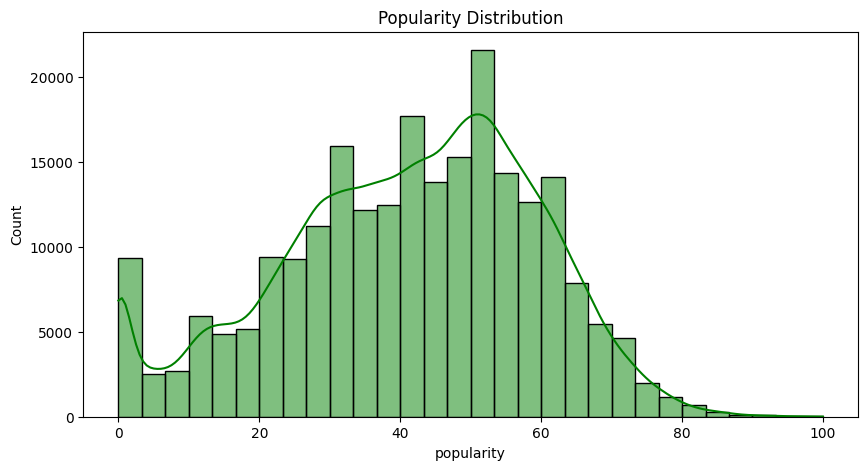

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(df['popularity'], bins=30, kde=True, color="green")
plt.title("Popularity Distribution")
plt.savefig("../outputs/popularity_distribution.png")
plt.show()


# Energy vs Valence (Mood Map)

Connects directly with your mood-based playlist generator.

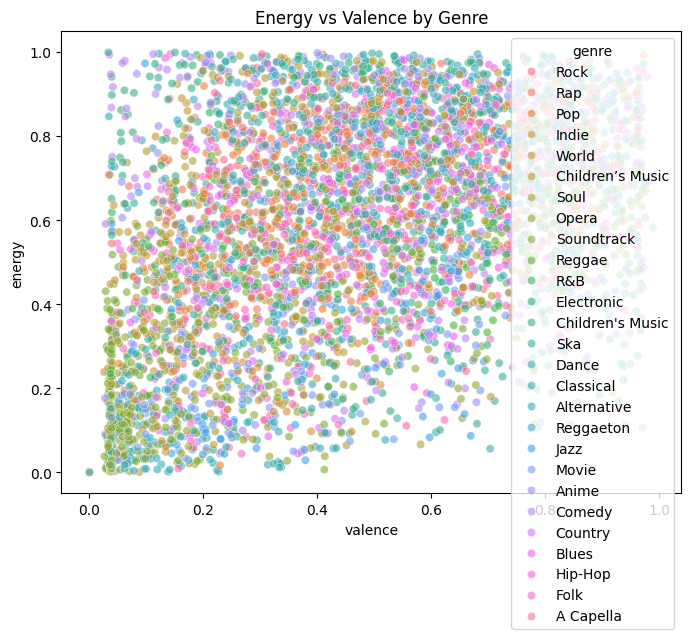

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='valence', y='energy', hue='genre', data=df.sample(5000), alpha=0.6)
plt.title("Energy vs Valence by Genre")
plt.savefig("../outputs/energy_valence.png")
plt.show()


# Correlation Heatmap of Audio Features

Shows relationships between features like danceability, energy, valence.

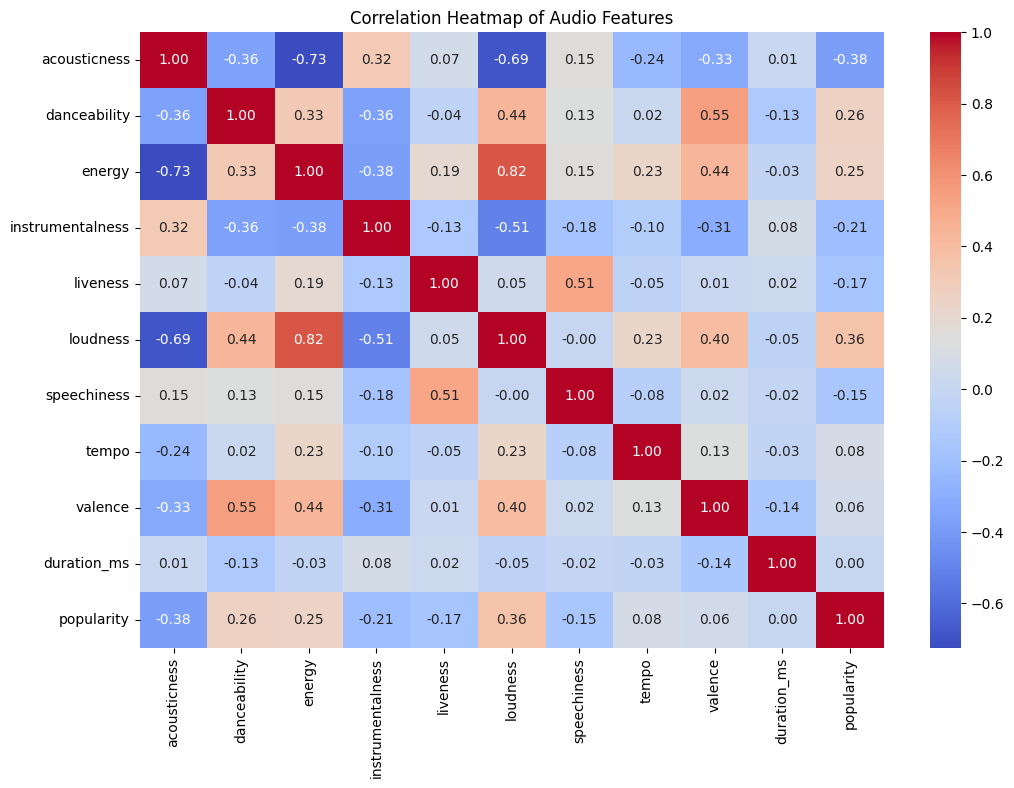

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.savefig("../outputs/feature_correlation.png")
plt.show()
